# Evaporation 

## Objectives

- Apply the water balance equation to estimate long-term average catchment evaporation

- Apply the Budyko equation to explore the fundamental limits on catchment water availability

- Visualize the range of aridity and evaporative fraction values in UK catchments 


We will start by loading the CAMELS data that we have used previously, and working through the analysis using an arbitrary catchment:

In [ ]:
import os
from pathlib import Path

SHARED_DATADIR = Path(os.environ["SHARED_DATA_DIR"])
DATADIR = SHARED_DATADIR / '8344e4f3-d2ea-44f5-8afa-86d2987543a9' / 'data'

In [20]:
import pandas as pd
id = '97002'
data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
data['id'] = id
data.head()

,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed,id
0,1970-10-01,9.93,1.02,8.91,NaN,NaN,1.31,6.01,61.76,325.33,7.65,97002
1,1970-10-02,4.01,1.41,7.66,NaN,NaN,1.76,5.11,93.56,294.20,10.03,97002
2,1970-10-03,7.27,1.17,8.77,NaN,NaN,1.40,5.41,61.95,321.14,5.41,97002
3,1970-10-04,3.77,0.06,9.74,NaN,NaN,0.23,7.76,42.83,341.28,7.27,97002
4,1970-10-05,1.19,1.56,9.46,NaN,NaN,1.86,5.49,92.13,299.08,7.90,97002


In the first week we calculated the annual actual evaporation by applying the catchment water balance equation. You should have written a loop to do this for many catchments. 

In [21]:
data['water_year'] = data['date'].dt.to_period('Y-SEP')
data.head()

,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed,id,water_year
0,1970-10-01,9.93,1.02,8.91,NaN,NaN,1.31,6.01,61.76,325.33,7.65,97002,1971
1,1970-10-02,4.01,1.41,7.66,NaN,NaN,1.76,5.11,93.56,294.20,10.03,97002,1971
2,1970-10-03,7.27,1.17,8.77,NaN,NaN,1.40,5.41,61.95,321.14,5.41,97002,1971
3,1970-10-04,3.77,0.06,9.74,NaN,NaN,0.23,7.76,42.83,341.28,7.27,97002,1971
4,1970-10-05,1.19,1.56,9.46,NaN,NaN,1.86,5.49,92.13,299.08,7.90,97002,1971


In [22]:
data = data.dropna(subset=['precipitation', 'pet', 'peti', 'discharge_spec'])
data = data.groupby(['id', 'water_year']).agg(
    precipitation=('precipitation', 'sum'),
    peti=('peti', 'sum'),
    pet=('pet', 'sum'),
    discharge_spec=('discharge_spec', 'sum'),
    valid_count=('id', 'count')  # Count non-NaN rows in 'precipitation'
).reset_index()
data = data[data['valid_count'] > (365 * 0.95)]
data['aet'] = data['precipitation'] - data['discharge_spec']
data = data.groupby(['id'])[['precipitation', 'peti', 'pet', 'discharge_spec', 'aet']].sum()

Now let's compute the evaporative fraction (actual evaporation divided by precipitation) and aridity (potential evaporation divided by precipitation):

In [23]:
data['evaporative_fraction'] = data['aet'] / data['precipitation']
data['aridity_index'] = data['peti'] / data['precipitation']
data.head()

,precipitation,peti,pet,discharge_spec,aet,evaporative_fraction,aridity_index
id,,,,,,,
97002,47092.45,20068.04,17697.72,29943.8,17148.65,0.364149,0.426141


Is the catchment energy limited or water limited? 

Now I would like you to plot the Budyko curve using every catchment in the CAMELS-GB dataset. However, I would like you to implement some data quality procedures: 

1. Exclude water years with less than 95% data availability; 
2. Exclude catchments with fewer than 20 years that meet criteria (1). 

To get you started I have read in one of the metadata files to retrieve the list of catchment IDs, and started off the loop. 

In [ ]:
from tqdm import tqdm

metadata = pd.read_csv(os.path.join(DATADIR, f'CAMELS_GB_topographic_attributes.csv'))
metadata['gauge_id'] = metadata['gauge_id'].astype(str)
catchment_ids = metadata['gauge_id'].to_list()

results = []
for id in tqdm(catchment_ids):
    data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
    data['id'] = id

    data['water_year'] = data['date'].dt.to_period('Y-SEP')

    # Do something here 

    # Quality control and aggregation
    data = data.dropna(subset=['precipitation', 'pet', 'peti', 'discharge_spec'])
    data = data.groupby(['id', 'water_year']).agg(
        precipitation=('precipitation', 'sum'),
        peti=('peti', 'sum'),
        pet=('pet', 'sum'),
        discharge_spec=('discharge_spec', 'sum'),
        valid_count=('id', 'count')  # Count non-NaN rows in 'precipitation'
    ).reset_index()
    data = data[data['valid_count'] > (365 * 0.95)]

    # Estimate AET as the difference between long-term precipitation and discharge
    data = data.groupby(['id'])[['precipitation', 'peti', 'pet', 'discharge_spec']].sum()
    data['aet'] = data['precipitation'] - data['discharge_spec']

    # Calculate the evaporative fraction and aridity index
    data['evaporative_fraction'] = data['aet'] / data['precipitation']
    data['aridity_index'] = data['peti'] / data['precipitation']

    if data.shape[0] > 1: 
        raise NotImplementedError()

    results.append(data)

data = pd.concat(results).reset_index(drop=True)
data.head()
    

100%|██████████| 671/671 [00:17<00:00, 38.16it/s]


,precipitation,peti,pet,discharge_spec,aet,evaporative_fraction,aridity_index
0,36806.74,22550.74,20373.87,21014.87,15791.87,0.429048,0.612680
1,27431.67,16234.88,14738.43,15612.51,11819.16,0.430858,0.591830
2,19597.25,9088.22,8043.28,11731.53,7865.72,0.401369,0.463750
3,30968.41,20815.51,19748.28,11899.82,19068.59,0.615743,0.672153
4,27818.38,18806.42,17786.26,9634.40,18183.98,0.653668,0.676043


Let's apply some QC procedures on this data:

In [25]:
data = data[(data['evaporative_fraction'] > 0) & (data['evaporative_fraction'] <= 1)]


Now you have calculated the evaporative fraction and aridity for every basin you can make the plot. Your plot should have: 
1. Aridity index on x-axis
2. Evaporative fraction on y-axis
3. A line showing the theoretical Budyko curve
4. Two straight lines showing the theoretical energy and water limits 
5. A point for every catchment (computed above). 

For reference, the Budyko equation can be expressed: 

<!-- $\frac{\overline{E}}{\overline{P}} = \left\{(1 - \exp{$-\frac{\overline{E_p}}{\overline{P}}}\right\}$ -->
$\frac{\overline{E}}{\overline{P}} = \left\{1 - \exp{\left({-\frac{\overline{E_p}}{\overline{P}}}\right)}\right\}$

To create the theoretical Budyko curve, create a vector of numbers between 0 and 5 representing $\frac{\overline{E_p}}{\overline{P}}$:



In [26]:
import numpy as np
aridity_vals = np.arange(0, 5.1, 0.1)
evaporative_fraction_vals = 1 - np.exp(-aridity_vals)

Now supply these values to the above equation to get the predicted evaporative fraction. 

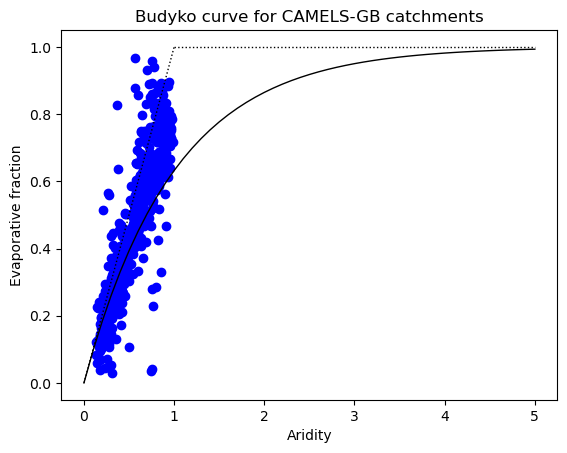

In [ ]:
import matplotlib.pyplot as plt

plt.plot(aridity_vals, evaporative_fraction_vals, label=None, color="black", linestyle="-", linewidth=1)

# Add bounds
plt.plot([0, 1], [0, 1], linestyle=":", color="black", linewidth=1)  # Vertical line at x=0
plt.plot([1, 5], [1, 1], linestyle=":", color="black", linewidth=1)  # Vertical line at x=1

plt.scatter(data['aridity_index'].values, data['evaporative_fraction'].values, color="b", marker="o")

# Add labels and title
plt.xlabel("Aridity")
plt.ylabel("Evaporative fraction")
plt.title("Budyko curve for CAMELS-GB catchments")

ax = plt.gca()
ax.set_xlim([0, 3])
ax.set_ylim([0, 1])
# # Add a legend
# plt.legend()

# Show the plot
plt.show()